# Data Augmentation for Medical Datasets

> This script is for medical data augmentation. \
> All algorithms are final organized version.

## Packages

In [1]:
import os
import time
# import shap ## for XAI
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# import pingouin as pg
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [2]:
from numpy import dot
from numpy.linalg import norm

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.layers import Dense , Activation, Dropout, BatchNormalization
from keras.optimizers import Adam ,RMSprop
from keras.callbacks import Callback

from scipy.special import rel_entr
from scipy.stats import gaussian_kde
from scipy.spatial.distance import jensenshannon

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, train_test_split, ParameterGrid
from sklearn import decomposition, metrics
from sklearn.cluster import KMeans
from sklearn.metrics import cohen_kappa_score,f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import Normalizer, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE

from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Concatenate, Dense, Lambda, Conv1D, Flatten, Reshape, UpSampling1D, MaxPooling1D, concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.losses import mse, MeanSquaredError

In [4]:
scaler = MinMaxScaler() #set the scaler (between 0 and 1)
# scaler = RobustScaler()

## Dataset

> We will apply various types/domains medical dataset. \
> It includes public dataset and even own collected medical datasets.

###  dataset check

In [54]:
data_ori = pd.read_csv('E:/RESEARCH/Datasets/bio_data/breast_cancer_wisconsin/data.csv') ## Wisconsin breast cancer dataset

In [55]:
print(f"The shape of the original dataset is: {data_ori.shape}")
data_ori.head()

The shape of the original dataset is: (569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [56]:
data_ori.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [57]:
num_missing_rows = data_ori.isna().any(axis=1).sum()
print(f"The number of rows that contains at least one missing value: {num_missing_rows}")

The number of rows that contains at least one missing value: 569


In [58]:
data_ori['diagnosis'].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

### Unnecessary feature elimination

> Unnecessary features varies according to the analysis purpose. \
> Researcher should provide research goal or purpose of the augmentation model.

In [59]:
drop_list = ['Unnamed: 32','id']
data_ori = data_ori.drop(drop_list, axis = 1 )

In [60]:
data_B = data_ori[data_ori['diagnosis']=="B"]
data_M = data_ori[data_ori['diagnosis']=="M"]

In [90]:
sample_B = data_B.sample(n=350, random_state=710674)
sample_M = data_M.sample(n=30, random_state=710674)

# 두 샘플을 합쳐서 최종 데이터프레임 구성
data_sampled = pd.concat([sample_B, sample_M])

***

***

# Data Augmentations

## dataset for model training

In [24]:
data = data_ori.copy()

In [26]:
data_vae = data.copy()
# data_vae = data_B.copy()
# data_vae = data_M.copy()

## Variational Autoencoder (VAE)

In [27]:
class Args_vae:
    # arugments
    epochs=130
    bs=32
    lr=0.0001
    momentum=0.9
    num_classes= 2
    latent_dim = 2
    seed=710674

args_vae = Args_vae()

### preparing x, y dataset

> Applying scaler on dataset prevents "nan loss" issue during VAE training

In [28]:
x = data_vae.drop("diagnosis", axis=1)
x = x.fillna(x.mean()) ## filling na values with mean values (just drop the rows is also a possible option)
y = data_vae.diagnosis

In [29]:
data_x = x.copy()
data_x[:] = (scaler.fit_transform(data_x[:])).round(decimals=6) ## scaling x values
label = y.copy()
label = label.replace({'B':0})
label = label.replace({'M': 1})
data_y = to_categorical(label, 2) ## into the format of one-hot encoding

In [30]:
print("The size of x dataset is:", data_x.shape)
print("The size of y dataset is:", data_y.shape)

The size of x dataset is: (569, 30)
The size of y dataset is: (569, 2)


### VAE model

In [ ]:
class VAE:
    def __init__(self, input_dim, latent_dim):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.encoder = None
        self.decoder = None
        self.vae = None
        self.build_model()
        self.callbacks = []

    ## VAE model for data augmentation
    def build_model(self):
        ####################################################
        ## defining encoder section
        inputs = Input(shape=(self.input_dim,))
        
        # shallow model use
        h = Dense(16, activation='relu')(inputs)

        # deeper model use
        # h = Dense(16, activation='relu')(inputs)
        # h = Dense(8, activation='relu')(h)
        # h = Dense(8, activation='relu')(h)

        # calculating mean/var
        z_mean = Dense(self.latent_dim)(h)
        z_log_var = Dense(self.latent_dim)(h)

        ## sampling section (for gaussian distribution)
        def sampling(args):
            z_mean, z_log_var = args
            batch = K.shape(z_mean)[0]
            dim = K.int_shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon

        z = Lambda(sampling, output_shape=(self.latent_dim,))([z_mean, z_log_var])

        ####################################################
        ## defining decoder section

        # shallower model use
        decoder_h = Dense(16, activation='relu')
        decoder_mean = Dense(self.input_dim, activation='sigmoid')
        h_decoded = decoder_h(z)
        x_decoded_mean = decoder_mean(h_decoded)
        
        # deeper model use
        # decoder_h1 = Dense(8, activation='relu')
        # decoder_h2 = Dense(16, activation='relu')
        # decoder_h3 = Dense(32, activation='relu')
        # decoder_mean = Dense(self.input_dim, activation='sigmoid')

        # h_decoded = decoder_h1(z)
        # h_decoded = decoder_h2(h_decoded)
        # h_decoded = decoder_h3(h_decoded)
        # x_decoded_mean = decoder_mean(h_decoded)

        ####################################################
        ## defining VAE model
        self.vae = Model(inputs, x_decoded_mean)

        ####################################################
        ## defining loss function (reconstruction + KL divergence)
        reconstruction_loss = MeanSquaredError()(inputs, x_decoded_mean)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var + K.epsilon()), axis=-1)
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        self.vae.add_loss(vae_loss)

        ####################################################
        ## compiling model
        self.vae.compile(optimizer=Adam(learning_rate=0.001))

        ####################################################
        ## Extracting encoder and decoder separately
        ## encoder section
        self.encoder = Model(inputs, z_mean)
        
        ## decoder section
        ### shallow model
        decoder_input = Input(shape=(self.latent_dim,))
        _h_decoded = decoder_h(decoder_input)
        _x_decoded_mean = decoder_mean(_h_decoded)
        self.decoder = Model(decoder_input, _x_decoded_mean)

        ### deeper model
        # decoder_input = Input(shape=(self.latent_dim,))
        # _h_decoded = decoder_h1(decoder_input)
        # _h_decoded = decoder_h2(_h_decoded)
        # _h_decoded = decoder_h3(_h_decoded)
        # _x_decoded_mean = decoder_mean(_h_decoded)
        # self.decoder = Model(decoder_input, _x_decoded_mean)
    
    ## Model training
    def train(self, data, epochs, batch_size, validation_split):
        self.vae.fit(data, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

    def encode(self, data):
        return self.encoder.predict(data)

    def decode(self, latent_points):
        return self.decoder.predict(latent_points)

    def generate_synthetic_data(self, n_samples):
        latent_samples = np.random.normal(size=(n_samples, self.latent_dim)) ## sampling from latent space
        return self.decode(latent_samples) ## synthetic data generation with decoder section

    def visualize_latent_space(self, data, labels):
        ## encode the dataset into latent space
        encoded_data = self.encode(data)
        ## latent space visualization with t-SNE
        tsne = TSNE(n_components=2, random_state=710674)
        encoded_data_tsne = tsne.fit_transform(encoded_data)
        ## Visualize
        plt.figure(figsize=(8, 6))
        plt.scatter(encoded_data_tsne[:, 0], encoded_data_tsne[:, 1], c=labels, cmap='viridis')
        plt.colorbar()
        plt.xlabel("t-SNE component 1")
        plt.ylabel("t-SNE component 2")
        plt.title("t-SNE visualization of the latent space")
        plt.show()

In [ ]:
vae = VAE(input_dim=data_x.shape[1], latent_dim=args_vae.latent_dim)
vae.train(data_x, epochs = args_vae.epochs, batch_size = args_vae.bs, validation_split=0.2)

### Latent space visualization

In [ ]:
vae.visualize_latent_space(data_x, label)

***

### Synthetic data generation

> We use two different synthetic data generation functions.
> 1. Adopting single VAE model(trained on all data classes)
> 2. Adopting individual VAE model for each data classes. 

#### single VAE model

In [ ]:
def generate_synthetic_data_for_classes(vae_model, latent_dim, class_labels, num_samples_per_class):
    synthetic_data = {}
    for class_label in class_labels:
        num_samples = num_samples_per_class[class_label]
        ## sampling from latent space
        z_samples = np.random.normal(size=(num_samples, latent_dim))
        ## use sampled data to generate synthetic dataset
        generated_samples = vae_model.decoder.predict(z_samples)
        ## save synthetic dataset with class label
        synthetic_data[class_label] = generated_samples
    return synthetic_data

In [ ]:
# 생성할 클래스 라벨들과 각 클래스별 생성할 샘플 수
num_samples_per_class = {0:212, 1:357}

# 각 클래스별 synthetic data 생성
synthetic_data = generate_synthetic_data_for_classes(vae, args_vae.latent_dim, label, num_samples_per_class)

In [ ]:
# 각 클래스에 대한 데이터프레임화
gen_B = pd.DataFrame(synthetic_data[0], columns=data_x.columns)
gen_M = pd.DataFrame(synthetic_data[1], columns=data_x.columns)
print(f"The synthetic data size is... \n\nSynthetic for B class: {gen_B.shape[0]} \nSynthetic for M class: {gen_M.shape[0]}")

> now move to "Classification performance check - Augmented datasets add"

***

#### individual VAE model

In [ ]:
def generate_class_synthetic_data_vae(vae_model, latent_dim, num_samples):
    ## sampling from latent space
    z_samples = np.random.normal(size=(num_samples, latent_dim))
    ## use sampled latent space vector to generate synthetic dataset
    synthetic_data = vae_model.decoder.predict(z_samples)
    return synthetic_data

In [ ]:
data_b, data_m = (data_B.drop("diagnosis", axis=1), data_M.drop("diagnosis", axis=1))
data_b[:] = (scaler.fit_transform(data_b[:])).round(decimals=6)
data_m[:] = (scaler.fit_transform(data_m[:])).round(decimals=6)

In [ ]:
# 클래스 B에 대한 VAE 모델 학습
vae_B = VAE(data_b.shape[1], latent_dim = args_vae.latent_dim)
vae_B.train(data_b, epochs=args_vae.epochs, batch_size=args_vae.bs, validation_split=0.2)

# 클래스 M에 대한 VAE 모델 학습
vae_M = VAE(data_m.shape[1], latent_dim = args_vae.latent_dim)
vae_M.train(data_m, epochs=args_vae.epochs, batch_size=args_vae.bs, validation_split=0.2)

In [ ]:
num_samples_per_class = {0:212, 1:357}

num_samples_B = num_samples_per_class[1]
synthetic_data_B = generate_class_synthetic_data_vae(vae_B, args_vae.latent_dim, num_samples_B)

num_samples_M = num_samples_per_class[0]
synthetic_data_M = generate_class_synthetic_data_vae(vae_M, args_vae.latent_dim, num_samples_M)

In [ ]:
## transform into the dataframe format
gen_B = pd.DataFrame(synthetic_data_B, columns=data_x.columns)
gen_M = pd.DataFrame(synthetic_data_M, columns=data_x.columns)

> now move to "Classification performance check - Augmented datasets add"

***

## Conditional Variational Autoencoder (CVAE)

> Advantage of CVAE is adding label or more information to increase explainability.

In [ ]:
class Args_cvae:
    # arugments
    epochs=130
    bs=32
    lr=0.0001
    momentum=0.9
    num_classes= 2
    latent_dim = 2
    seed=710674

args_cvae = Args_cvae()

### preparing x, y dataset

> Applying scaler on dataset prevents "nan loss" issue during VAE training

In [ ]:
data_cvae = data_ori_.copy()
data_cvae.columns

In [ ]:
x = data_cvae.drop("diagnosis", axis=1)
x = x.fillna(x.mean()) ## filling na values with mean values (just drop the rows is also a possible option)
y = data_cvae.diagnosis
# c = data_cvae.loc[:,["diagnosis"]]
c = data_cvae.iloc[:,0]

In [ ]:
data_x = x.copy()
data_x[:] = (scaler.fit_transform(data_x[:])).round(decimals=6) ## scaling x values
label = y.copy()
label = label.replace({'B':0})
label = label.replace({'M': 1})
data_y = to_categorical(label, 2) ## into the format of one-hot encoding
data_c = c.copy()

In [ ]:
label.value_counts()

In [ ]:
print("The size of x dataset is:", data_x.shape)
print("The size of y dataset is:", data_y.shape)
print("The size of c dataset is:", data_c.shape)

### CVAE model

In [ ]:
class CVAE:
    def __init__(self, input_dim, condition_dim, latent_dim):
        ## initializing data demensionality
        self.input_dim = input_dim
        self.condition_dim = condition_dim
        self.latent_dim = latent_dim
        
        ## generating encoder and decoder section
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.cvae = self.build_cvae()
    
    ## defining encoder function
    def build_encoder(self):
        x_input = layers.Input(shape=(self.input_dim,), name='input')
        c_input = layers.Input(shape=(self.condition_dim,), name='condition')
        
        combined_input = layers.Concatenate()([x_input, c_input])
        
        h = layers.Dense(16, activation='relu')(combined_input)
        # h = layers.Dense(32, activation='relu')(h)
        
        z_mean = layers.Dense(self.latent_dim, name='z_mean')(h)
        z_log_var = layers.Dense(self.latent_dim, name='z_log_var')(h)
        
        ## sampling (reparameterization)
        def sampling(args):
            z_mean, z_log_var = args
            batch = K.shape(z_mean)[0]
            dim = K.int_shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon
        
        z = layers.Lambda(sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])
        
        return Model([x_input, c_input], [z_mean, z_log_var, z], name='encoder')
    
    ## defining decoder function
    def build_decoder(self):
        z_input = layers.Input(shape=(self.latent_dim,), name='z_sampling')
        c_input = layers.Input(shape=(self.condition_dim,), name='condition')
        
        combined_input = layers.Concatenate()([z_input, c_input])
        
        h = layers.Dense(16, activation='relu')(combined_input)
        # h = layers.Dense(64, activation='relu')(h)
        x_decoded = layers.Dense(self.input_dim, activation='sigmoid', name='output')(h)
        
        return Model([z_input, c_input], x_decoded, name='decoder')
    
    ## build and compile the CVAE model
    def build_cvae(self):
        x_input = layers.Input(shape=(self.input_dim,), name='input')
        c_input = layers.Input(shape=(self.condition_dim,), name='condition')
        
        z_mean, z_log_var, z = self.encoder([x_input, c_input])
        x_decoded = self.decoder([z, c_input])
        
        cvae = Model([x_input, c_input], x_decoded, name='cvae')
        
        reconstruction_loss = mse(x_input, x_decoded)
        reconstruction_loss *= self.input_dim
        
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        
        cvae_loss = K.mean(reconstruction_loss + kl_loss)
        cvae.add_loss(cvae_loss)
        cvae.compile(optimizer='adam')
        
        return cvae
    
    ## model training
    def train(self, x_data, c_data, epochs, batch_size, validation_split):
        self.cvae.fit([x_data, c_data], epochs=epochs, batch_size=batch_size, validation_split = validation_split)
    
    ## synthetic data generation (for data augmentation)
    def generate_synthetic_data(self, condition, n_samples=1):
        z_samples = np.random.normal(size=(n_samples, self.latent_dim))
        synthetic_data = self.decoder.predict([z_samples, condition])
        return synthetic_data
        
    def visualize_latent_space(self, x_data, c_data, labels, n_samples):
        n_samples = min(n_samples, len(x_data), len(c_data))
        indices = np.random.choice(len(x_data), n_samples, replace=False) ## data sampling for n
        x_sample = x_data.iloc[indices]
        c_sample = c_data[indices]
        z_mean, _, _ = self.encoder.predict([x_sample, c_sample]) ## calculating latent vector z
        tsne = TSNE(n_components=2, random_state=710674) #tsne visualization
        z_tsne = tsne.fit_transform(z_mean)

        ## visualization
        plt.figure(figsize=(8, 6))
        if labels is not None:
            plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels[indices], cmap='viridis')
            plt.colorbar()
        else:
            plt.scatter(z_tsne[:, 0], z_tsne[:, 1])
        plt.title('t-SNE visualization of the latent space')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.show()

In [ ]:
cvae = CVAE(input_dim = data_x.shape[1], condition_dim = data_y.shape[1], latent_dim=args_cvae.latent_dim)
cvae.train(data_x, data_y, epochs=args_cvae.epochs, batch_size=args_cvae.bs, validation_split=0.2)

### Latent space visualization

In [ ]:
cvae.visualize_latent_space(data_x, data_y, label, n_samples=500)

### Synthetic data generation

* This section is to generate synthetic data using trained CVAE model

#### single CVAE model

In [ ]:
def generate_class_synthetic_data(cvae_model, c_data, n_samples_per_class, labels, method):
    synthetic_data = {}
    new_conditions = {}

    for class_label, n_samples in n_samples_per_class.items():
        ## filtering the condition for each class
        class_indices = np.where(labels == class_label)[0]
        class_conditions = c_data[class_indices]
        
        ## generating new condition for conditional VAE data augmentation
        ## randomly sampling from the original condition dataset
        if method == 'random':
            indices = np.random.choice(len(class_conditions), n_samples, replace=True)
            class_new_conditions = class_conditions[indices]
        ## calculate mean and variance from origianl condition dataset to sampling
        elif method == 'gaussian':
            mean = np.mean(class_conditions, axis=0)
            std = np.std(class_conditions, axis=0)
            class_new_conditions = np.random.normal(loc=mean, scale=std, size=(n_samples, class_conditions.shape[1]))
        
        ## generate synthetic dataset for each class with new conditions
        class_synthetic_data = cvae_model.generate_synthetic_data(class_new_conditions, n_samples=n_samples)
        
        ## save the synthesized results
        synthetic_data[class_label] = class_synthetic_data
        new_conditions[class_label] = class_new_conditions
    
    # return synthetic_data, new_conditions
    return synthetic_data

In [ ]:
n_samples_per_class = {0:212, 1:357}

## synthetic data generation (augmentation)
synthetic_data = generate_class_synthetic_data(cvae, data_y, n_samples_per_class, label, method='random')
# synthetic_data = generate_class_synthetic_data(cvae, data_y, n_samples_per_class, label, method='gaussian')

# print("\n=====================================")
# print("Class 0 - Generated Synthetic Data: ")
# print(synthetic_data[0])
# print("\n=====================================")
# print("\nClass 1 - Generated Synthetic Data:")
# print(synthetic_data[1])

In [ ]:
def synthetic_dataframe(synthetic_data, data_x):
    dataframes = {}
    for class_label, data in synthetic_data.items():
        data_copy = data.copy()
        df = pd.DataFrame(data_copy, columns=data_x.columns)
        dataframes[class_label] = df
    return dataframes

In [ ]:
dataframes = synthetic_dataframe(synthetic_data, data_x)

# 클래스 0과 클래스 1에 대한 데이터프레임 추출
gen_B = dataframes[0]
gen_M = dataframes[1]

***

#### individual CVAE model

In [ ]:
## we should train individual CVAE model for each class
cvae_models = {}

for class_label in np.unique(label):
    ## data filtering to find dataset with that class label
    class_indices = np.where(label == class_label)[0]
    class_data = data_x.iloc[class_indices]
    
    ## initialize and train CVAE model
    cvae = CVAE(input_dim=data_x.shape[1], latent_dim=args_cvae.latent_dim, condition_dim=data_y.shape[1])
    cvae.train(class_data, data_y[class_indices], epochs=args_cvae.epochs, batch_size=args_cvae.bs, validation_split=0.2)
    
    ## save the trained model
    cvae_models[class_label] = cvae

In [ ]:
def generate_class_synthetic_data_seperately(cvae_models, c_data, n_samples_per_class, method):
    synthetic_data = {}
    new_conditions = {}

    for class_label, n_samples in n_samples_per_class.items():
        ## loading trained CVAE model for each class
        cvae_model = cvae_models[class_label]
        
        ## filtering the condition for the class
        class_indices = np.where(label == class_label)[0]
        class_conditions = c_data[class_indices]

        ## generating new condition for conditional VAE data augmentation
        ## randomly sampling from the original condition dataset
        if method == 'random':
            indices = np.random.choice(len(class_conditions), n_samples, replace=True)
            class_new_conditions = class_conditions[indices]
        ## calculate mean and variance from origianl condition dataset to sampling
        elif method == 'gaussian':
            mean = np.mean(class_conditions, axis=0)
            std = np.std(class_conditions, axis=0)
            class_new_conditions = np.random.normal(loc=mean, scale=std, size=(n_samples, class_conditions.shape[1]))
        
        ## generate synthetic dataset for each class with new conditions
        class_synthetic_data = cvae_model.generate_synthetic_data(class_new_conditions, n_samples=n_samples)
        
        ## save the synthesized results
        synthetic_data[class_label] = class_synthetic_data
        new_conditions[class_label] = class_new_conditions
    
    # return synthetic_data, new_conditions
    return synthetic_data

In [ ]:
n_samples_per_class = {0:212, 1:357}

synthetic_data = generate_class_synthetic_data_seperately(cvae_models, data_y, n_samples_per_class, method="random")
# synthetic_data = generate_class_synthetic_data_seperately(cvae_models, data_y, n_samples_per_class, method="gaussian")

# print("\n=====================================")
# print("Class 0 - Generated Synthetic Data: ")
# print(synthetic_data[0])
# print("\n=====================================")
# print("\nClass 1 - Generated Synthetic Data:")
# print(synthetic_data[1])

***

***

# Classification performance check

## Original dataset only

In [91]:
# data_dnn = data_ori.copy()
data_dnn = data_sampled.copy()

In [92]:
x = data_dnn.drop("diagnosis", axis=1)
x = x.fillna(x.mean()) ## filling na values with mean values (just drop the rows is also a possible option)
y = data_dnn.diagnosis

In [93]:
data_x = x.copy()
data_x[:] = (scaler.fit_transform(data_x[:])).round(decimals=6) ## scaling x values

label = y.copy()
label = label.replace({'B':0})
label = label.replace({'M': 1})
data_y = to_categorical(label, 2) ## into the format of one-hot encoding

In [94]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.2, random_state = 710674)

In [95]:
## definition for computing class weight (to solve class imbalance issue)
def compute_class_weights(y):
    class_counts = np.bincount(y) ## calculating data point for each class
    total_samples = len(y) ## total data points
    ## computing each class weight
    class_weights = {i: total_samples / (len(class_counts) * class_count) 
                     for i, class_count in enumerate(class_counts)}
    
    return class_weights

In [96]:
class_weight = compute_class_weights(label)
print(class_weight)

{0: 0.5428571428571428, 1: 6.333333333333333}


## Augmented dataset add

In [ ]:
class cvae_data_preparation:
    def __init__(self, original_data, gen_data, label_col, id_cols=None, drop_cols=None):
        """
        original_data (pandas.DataFrame): original dataset
        gen_data (dict): data dictionary for synthetic dataset (ex: {0: gen_A, 1: gen_B})
        label_col (str): label column (target variable)
        id_cols (list): column list to drop (예: ['Unnamed: 32', 'id'])
        drop_cols (list): column list to drop from original dataset
        """
        self.original_data = original_data
        self.gen_data = gen_data
        self.label_col = label_col
        self.id_cols = id_cols if id_cols is not None else []
        self.drop_cols = drop_cols if drop_cols is not None else []
        
    def prepare_data(self):
        ## preprocessing original dataset
        data_dnn = self.original_data.copy()
        for col in self.id_cols:
            if col in data_dnn.columns:
                data_dnn = data_dnn.drop(col, axis=1)
        
        data_dnn = data_dnn.drop(self.drop_cols, axis=1)
        data_classes = {label: data_dnn[data_dnn[self.label_col] == label] for label in data_dnn[self.label_col].unique()}
        
        ## preprocessing synthetic generated dataset
        for label, df in self.gen_data.items():
            df[self.label_col] = label
            if self.drop_cols:
                df = df.drop(self.drop_cols, axis=1)
            self.gen_data[label] = df
        
        ## concat original dataset and generated dataset
        ori_df_concat = pd.concat(list(data_classes.values()), ignore_index=True)
        gen_df_concat = pd.concat(list(self.gen_data.values()), ignore_index=True)
        
        ## separating feature and label(target)
        ori_x = ori_df_concat.drop([self.label_col], axis=1)
        ori_y = ori_df_concat[[self.label_col]]
        
        gen_x = gen_df_concat.drop([self.label_col], axis=1)
        gen_y = gen_df_concat[[self.label_col]]
        
        ## filling missing values and scaling
        ori_x = ori_x.fillna(ori_x.mean())
        ori_x[:] = (scaler.fit_transform(ori_x[:])).round(decimals=6) ## scaling x values
        
        # 레이블 인코딩 및 원-핫 인코딩
        ori_y = ori_y.replace({self.label_col: {label: idx for idx, label in enumerate(ori_y[self.label_col].unique())}})
        y_ori = to_categorical(ori_y, num_classes=len(ori_y[self.label_col].unique()))
        
        gen_y = gen_y.replace({self.label_col: {label: idx for idx, label in enumerate(gen_y[self.label_col].unique())}})
        y_gen = to_categorical(gen_y, num_classes=len(gen_y[self.label_col].unique()))
        
        ## separating training and test dataset
        x_trainset, x_test, y_trainset, y_test = train_test_split(ori_x, y_ori, test_size=0.35, random_state=710674)
        
        ## add generated dataset to training dataset
        x_train_concat = pd.concat([x_trainset, gen_x], ignore_index=True)
        y_train_concat = np.concatenate([y_trainset, y_gen])
        
        ## separating training dataset and validation dataset
        x_train, x_vali, y_train, y_vali = train_test_split(x_train_concat, y_train_concat, test_size=0.2, random_state=710674)
        
        return x_train, x_vali, x_test, y_train, y_vali, y_test

In [ ]:
## make a dictionary for generated dataset
gen_data = {"B": gen_B, "M": gen_M }

## data_preparation class initialize and data prepare
data_prep = cvae_data_preparation(data_ori, gen_data, label_col='diagnosis', id_cols=['Unnamed: 32', 'id'])
x_train, x_vali, x_test, y_train, y_vali, y_test = data_prep.prepare_data()

In [ ]:
print(f"The final datset size is... \nTraining dataset: {x_train.shape[0]} \nValidation dataset: {x_vali.shape[0]} \nTest dataset: {x_test.shape[0]}")

## Simple DNN model

> To compare classification performance, we design simple structure of DNN.

In [97]:
class Args_dnn:
    # arugments
    epochs=50
    bs=32
    lr=0.0001
    momentum=0.9
    num_classes= 2
    seed=710674

args_dnn = Args_dnn()

### DNN model

In [98]:
class SimpleDNN:
    def __init__(self, input_dim, layer_configs, output_units, output_activation='softmax'):
        self.input_dim = input_dim ## input data dimensionality (# variables)
        self.layer_configs = layer_configs ## hidden layer/sequential layer lists (units, activation, batch_norm, dropout_rate)
        self.output_units = output_units ## output unit no.
        self.output_activation = output_activation ## activation function for output layer
        self.model = self.build_model()
        self.callbacks = []

    def build_model(self):
        model = models.Sequential()
        ## add first hidden layer
        model.add(layers.Dense(units=self.layer_configs[0]['units'], activation=self.layer_configs[0]['activation'], input_shape=(self.input_dim,)))
        
        ## batch normalization and dropout for first layer
        if self.layer_configs[0].get('batch_norm', False):
            model.add(layers.BatchNormalization())
        if self.layer_configs[0].get('dropout_rate', None) is not None:
            model.add(layers.Dropout(rate=self.layer_configs[0]['dropout_rate']))
        
        ## do same for rest hidden layers (except for the last)
        for config in self.layer_configs[1:]:
            model.add(layers.Dense(units=config['units'], activation=config['activation']))
            
            if config.get('batch_norm', False):
                model.add(layers.BatchNormalization())
            
            if config.get('dropout_rate', None) is not None:
                model.add(layers.Dropout(rate=config['dropout_rate']))
        
        ## add output layer
        model.add(layers.Dense(units=self.output_units, activation=self.output_activation))
        
        return model

    def compile_model(self, optimizer, loss='categorical_crossentropy', metrics=['accuracy'], lr_scheduler=None, class_weight=None):
        if lr_scheduler:
            ## AddLearningRateScheduler callback
            self.callbacks.append(LearningRateScheduler(lr_scheduler))
        
        self.model.compile(optimizer, loss, metrics)

    def fit_model(self, x_train, y_train, epochs, batch_size, validation_split=None, class_weight=None, validation_data=None):
        return self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                             class_weight=class_weight, validation_data = validation_data, callbacks=self.callbacks)

    def evaluate_model(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def predict(self, x):
        return self.model.predict(x)

    def summary(self):
        self.model.summary()

In [99]:
def dynamic_learning_rate(epoch, mode='cyclic', base_lr=0.001, max_lr=0.006, step_size=2000, gamma=0.99994):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    
    if mode == 'cyclic' or mode == 'triangular':
        lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    elif mode == 'triangular2':
        lr = base_lr + (max_lr - base_lr) * max(0, (1 - x)) / (2 ** (cycle - 1))
    elif mode == 'exp_range':
        lr = base_lr + (max_lr - base_lr) * max(0, (1 - x)) * (gamma ** epoch)
    else:
        raise ValueError("Invalid mode. Choose from 'cyclic', 'triangular', 'triangular2', or 'exp_range'.")
    
    return lr

In [100]:
# lr = dynamic_learning_rate(epoch=1000, mode='cyclic')
# lr = dynamic_learning_rate(epoch=1000, mode='triangular')
# lr = dynamic_learning_rate(epoch=1000, mode='triangular2')
# lr = dynamic_learning_rate(epoch=1000, mode='exp_range', gamma=0.99994)

In [101]:
x_train.shape

(304, 30)

In [102]:
## model initialization with hidden layer list below
layer_configs = [
    {'units': 32, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.5},
    {'units': 16, 'activation': 'relu', 'batch_norm': False, 'dropout_rate': 0.3},
    {'units': 8, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.2}
]

model = SimpleDNN(output_units=args_dnn.num_classes, input_dim=x_train.shape[1], layer_configs=layer_configs)

In [103]:
## compile our model
opt = keras.optimizers.SGD(learning_rate = 0.001, decay = 1e-5, momentum = 0.9)
scheduler = lambda epoch: dynamic_learning_rate(epoch, mode='triangular2', base_lr=0.001, max_lr=0.009, step_size=25)
model.compile_model(optimizer = opt, lr_scheduler=scheduler)

## model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                992       
                                                                 
 batch_normalization_8 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                      

In [104]:
## model training on training dataset
history = model.fit_model(x_train, y_train, epochs=args_dnn.epochs, batch_size=args_dnn.bs, validation_split=0.2)
# history = model.fit_model(x_train, y_train, epochs=args_dnn.epochs, batch_size=args_dnn.bs, class_weight = class_weight, validation_split=0.2)

Epoch 1/50
8/8 [==============================] - 1s 30ms/step - loss: 1.2209 - accuracy: 0.3457 - val_loss: 0.6625 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 1.0301 - accuracy: 0.3909 - val_loss: 0.6249 - val_accuracy: 0.9016 - lr: 0.0013
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.8330 - accuracy: 0.4979 - val_loss: 0.5723 - val_accuracy: 0.9016 - lr: 0.0016
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.7123 - accuracy: 0.6008 - val_loss: 0.5139 - val_accuracy: 0.9016 - lr: 0.0020
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.5790 - accuracy: 0.6831 - val_loss: 0.4637 - val_accuracy: 0.9016 - lr: 0.0023
Epoch 6/50
8/8 [==============================] - 0s 10ms/step - loss: 0.5363 - accuracy: 0.7572 - val_loss: 0.4230 - val_accuracy: 0.9016 - lr: 0.0026
Epoch 7/50
8/8 [==============================] - 0s 11ms/step - loss: 0.4822 - accuracy

### Evaluation

In [105]:
def evaluate_model_performance(model, x_test, y_test):

    ## predict on model
    y_predict = model.predict(x_test)
    y_predict_classes = np.argmax(y_predict, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    ## calculate confusion matrix and visualize
    cm = confusion_matrix(y_test_classes, y_predict_classes, normalize='pred')
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='.2f')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()
    
    ## evaluation metrics
    accuracy = metrics.accuracy_score(y_test_classes, y_predict_classes)
    precision = metrics.precision_score(y_test_classes, y_predict_classes, average='macro')
    recall = metrics.recall_score(y_test_classes, y_predict_classes, average='micro')
    f1 = metrics.f1_score(y_test_classes, y_predict_classes, average='weighted')
    auc = roc_auc_score(y_test, y_predict, multi_class='ovr')
    
    ## Results
    print("=============================================")
    print(f"The overall accuracy is: {accuracy:.4f}")
    print(f"The precision score is: {precision:.4f}")
    print(f"The recall score is: {recall:.4f}")
    print(f"The F1 score is: {f1:.4f}")
    print(f"The AUC score is: {auc:.4f}")
    print("=============================================")
    
    ## Print out the classification report
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_predict_classes))

3/3 [==============================] - 0s 2ms/step


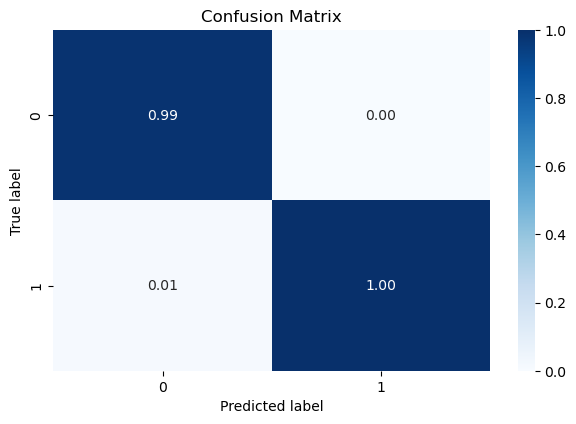

The overall accuracy is: 0.9868
The precision score is: 0.9933
The recall score is: 0.9868
The F1 score is: 0.9847
The AUC score is: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        74
           1       1.00      0.50      0.67         2

    accuracy                           0.99        76
   macro avg       0.99      0.75      0.83        76
weighted avg       0.99      0.99      0.98        76



In [106]:
evaluate_model_performance(model, x_test, y_test)

***

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def adjust_synthetic_data_distribution(original_data, synthetic_data):
    # 원래 데이터의 평균과 분산을 계산
    scaler = StandardScaler()
    scaler.fit(original_data)
    
    # 원래 데이터의 평균과 분산
    original_mean = scaler.mean_
    original_std = scaler.scale_
    
    # synthetic data의 평균과 분산을 계산
    synthetic_scaler = StandardScaler()
    synthetic_scaler.fit(synthetic_data)
    
    # synthetic data를 원래 데이터의 평균과 분산으로 조정
    adjusted_synthetic_data = synthetic_scaler.transform(synthetic_data)
    adjusted_synthetic_data = adjusted_synthetic_data * original_std + original_mean
    
    return adjusted_synthetic_data

# 예시 데이터
data_x = np.random.rand(1000, 20)  # 원래 데이터 (예: 1000개의 샘플, 20개의 피쳐)
synthetic_data = np.random.rand(500, 20)  # synthetic 데이터 (예: 500개의 샘플, 20개의 피쳐)

# 데이터 분포 조정
adjusted_synthetic_data = adjust_synthetic_data_distribution(data_x, synthetic_data)